In [1]:
import os, glob 
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import torch
import albumentations as A
from distributed_sampler_no_evenly_divisible import *
import torch.utils.data.distributed 
from rs_data import to_numpy, compare_plot

## NYU 

In [46]:
#load images 
root = '/mnt/520ED4640ED44321/ZMH/datasets/depth_dataset/nyu+diode+rs'
mode = 'train'
# nyu
imgs = []
imgs = glob.glob(os.path.join(root, 'train') + '**/**/*.jpg', recursive = True)
# diode (outdoor) + rs
for img in glob.glob(os.path.join(root,'train') + '**/**/*.png', recursive = True):
    if not 'sync' in img:
        imgs.append(img)

len(imgs)


155

In [66]:
def show(img):
    if img.ndim == 2:
        img = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha = 0.0355), cv2.COLORMAP_JET)
    cv2.imshow('Image', img); cv2.waitKey(0); cv2.destroyAllWindows()
    

In [98]:
def add_mask(depth_gt, depth_mask):
    MIN_DEPTH = 0.0
    MAX_DEPTH = min(300, np.percentile(depth_gt, 99))
    depth_gt = np.clip(depth_gt, MIN_DEPTH, MAX_DEPTH) 
    depth_gt[depth_mask==0] = 0
    return depth_gt 

def load_and_preprocess(rgb_path, depth_path, mask_path, dataset):
    image = Image.open(rgb_path).convert('RGB')
    image = np.array(image, dtype = np.uint8)
    
    if dataset == 'diode':
        depth_gt = np.load(depth_path).squeeze()
        depth_mask = np.load(mask_path)
        depth_gt = add_mask(depth_gt, depth_mask)
        
    elif dataset == 'realsense':
        depth_gt = (np.load(depth_path) / 1000).astype('float32')
        depth_gt = depth_gt[45:472, 43:608]
        depth_gt[depth_gt > 10] = 0
        image = image[45:472, 43:608]
        
        
    elif dataset == 'nyu':
        depth_gt = Image.open(depth_path)
        depth_gt = np.asarray(depth_gt, dtype = np.float32) / 1000
        depth_gt = depth_gt[45:472, 43:608]
        image = image[45:472, 43:608]
 
    return image, depth_gt

def transform(aug, img):
    return aug(image = img)['image']

def sync_transform(aug, images, p):
    target = {'depth': 'image'}
    sample = A.Compose(aug, p = p, additional_targets= target)(image = images[0], depth = images[1])
    return sample

def augment(image, depth_gt, p = 0.3):
    
    augs = A.Compose([
        A.RandomGamma(gamma_limit = (80, 140)),
        A.RandomBrightnessContrast(),
    ], p = 0.3)
    
    image = transform(augs, image)
    
    # same augmentations with rgb and depth image
    sample = sync_transform([
        A.Resize( 416, 544, interpolation = cv2.INTER_NEAREST),
        A.HorizontalFlip(),
#         A.ShiftScaleRotate(shift_limit = 0.0625, scale_limit = 0.2, rotate_limit = 45)
    ], 
        [image, depth_gt], p)
    
    return sample

 
to_tensor = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.3947, 0.3610, 0.3366], [0.1965, 0.1943, 0.2006])
                ])
    

Enter index number: 144
torch.Size([3, 416, 544]) tensor(-2.0087) tensor(3.3071) torch.FloatTensor
torch.Size([1, 416, 544]) tensor(0.) tensor(9.9280) torch.FloatTensor


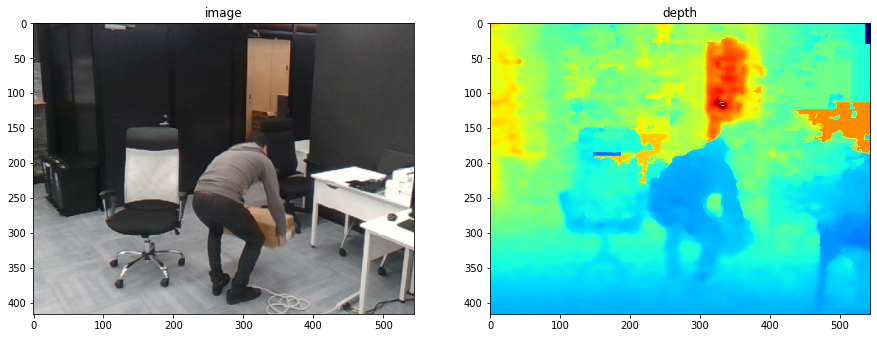

In [111]:
i = int(input('Enter index number: '))

if imgs[i].endswith('.jpg'): # nyu
    dataset = 'nyu'
    rgb_path = imgs[i]
    depth_path = rgb_path.replace('rgb_', 'sync_depth_')[:-4]+'.png'
    mask_path = None

elif not 'outdoors' in imgs[i]:
    dataset = 'realsense'
    rgb_path = imgs[i]
    depth_path = rgb_path[:-4] + '_depth.npy'
    mask_path = None

elif 'outdoors' in imgs[i]:
    dataset = 'diode'
    rgb_path = imgs[i]
    depth_path = rgb_path[:-4] + '_depth.npy'
    mask_path = rgb_path[:-4] + '_depth_mask.npy'

#print(dataset, imgs[i])

image, depth_gt = load_and_preprocess(rgb_path, depth_path, mask_path, dataset)
depth_gt = np.expand_dims(depth_gt, axis = 2)
if transform:
    sample = augment(image, depth_gt, p = 0.4)
    
image = to_tensor(sample['image']).type(torch.float32)
depth_gt = torch.from_numpy(sample['depth'].transpose(2, 0, 1))

print(image.shape, image.min(), image.max(), image.type())
print(depth_gt.shape, depth_gt.min(), depth_gt.max(), depth_gt.type())

compare_plot(figsize=(15, 15), cmap = 'jet', image = sample['image'], depth = sample['depth'].squeeze())

In [ ]:
# read images
rgb_path = imgs[0]
depth_path = rgb_path.replace('rgb_', 'sync_depth_')[:-4]+'.png'

